In [1]:
import os as os
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
import datetime as dt
plt.style.use('seaborn-whitegrid')

plt.rcParams['image.cmap'] = 'blue'

#sns.set_context('notebook',font_scale=2)
sns.set_style("whitegrid")
% matplotlib inline
plt.rcParams['font.size'] = 22
plt.rcParams.update({'figure.figsize': (20,10)})
plt.rcParams.update({'axes.titlesize': 'large'})
plt.rcParams.update({'axes.labelsize': 'large'})
# mpl.rcParams.keys()

In [2]:
!cd data && ls

2014-05 - Citi Bike trip data.csv	  taxi_tree_test_X_20130506-12.csv
bike_20140505_with_dist_and_avg_velo.csv  taxi_tree_test_X.csv
bike_20140505_with_dist.csv		  taxi_tree_test_Xy_20130506-12.csv
bike_20140505_with_dist_velo.csv	  taxi_tree_test_Xy.csv
bike_oneweekfrom20140505.csv		  taxi_tree_test_Xy_sample.csv
data_jan13.csv				  taxi_tree_test_y_20130506-12.csv
README.txt				  taxi_tree_test_y.csv
taxi_oneweekfrom20130107.csv		  yellow_tripdata_2013-05.csv
taxi_oneweekfrom20130506.csv		  yellow_tripdata_2014-05.csv
taxi_oneweekfrom20140505.csv


Use the bash =)

In [3]:
data = pd.read_csv('data/taxi_oneweekfrom20130506.csv', index_col=0, parse_dates=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3534632 entries, 0 to 3534631
Data columns (total 18 columns):
vendor_id             object
pickup_datetime       object
dropoff_datetime      object
passenger_count       int64
trip_distance         float64
pickup_longitude      float64
pickup_latitude       float64
rate_code             int64
store_and_fwd_flag    object
dropoff_longitude     float64
dropoff_latitude      float64
payment_type          object
fare_amount           float64
surcharge             float64
mta_tax               float64
tip_amount            float64
tolls_amount          float64
total_amount          float64
dtypes: float64(11), int64(2), object(5)
memory usage: 512.4+ MB


So parsing does not work, do it manually:

In [5]:
data['pickup_datetime'] =pd.to_datetime(data['pickup_datetime'], format = '%Y-%m-%d %H:%M:%S')
data['dropoff_datetime'] =pd.to_datetime(data['dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S')

In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
passenger_count,3534632.0,1.708266,1.380270,0.000000,1.000000,1.000000,2.000000,6.000000
trip_distance,3534632.0,2.875593,3.343748,0.000000,1.050000,1.800000,3.200000,100.000000
pickup_longitude,3534632.0,-72.621180,10.142067,-1625.033333,-73.992272,-73.981786,-73.966735,40.867882
pickup_latitude,3534632.0,39.981485,6.522288,-3113.281477,40.734916,40.752702,40.767551,2047.454950
rate_code,3534632.0,1.032870,0.345708,0.000000,1.000000,1.000000,1.000000,210.000000
dropoff_longitude,3534618.0,-72.575137,10.450838,-2038.393545,-73.991547,-73.980110,-73.963510,2386.995232
dropoff_latitude,3534618.0,39.952355,7.665360,-3114.304505,40.733845,40.753077,40.768337,3210.392762
fare_amount,3534632.0,12.491013,10.078369,2.500000,6.500000,9.500000,14.500000,500.000000
surcharge,3534632.0,0.320163,0.362772,0.000000,0.000000,0.000000,0.500000,9.500000
mta_tax,3534632.0,0.498208,0.029876,0.000000,0.500000,0.500000,0.500000,0.500000


In [7]:
data.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2013-05-06,2013-05-06 00:10:00,1,2.65,-73.981070,40.766047,1,NaN,-73.981362,40.738092,CRD,10.5,0.5,0.5,2.20,0.0,13.70
1,VTS,2013-05-06,2013-05-06 00:06:00,5,1.86,-73.986312,40.760487,1,NaN,-74.005082,40.743372,CSH,7.5,0.5,0.5,0.00,0.0,8.50
2,VTS,2013-05-06,2013-05-06 00:04:00,1,0.90,-73.989388,40.731577,1,NaN,-73.986102,40.740732,CSH,5.5,0.5,0.5,0.00,0.0,6.50
3,VTS,2013-05-06,2013-05-06 00:08:00,1,2.59,-73.994590,40.751857,1,NaN,-73.963470,40.765912,CSH,9.5,0.5,0.5,0.00,0.0,10.50
4,VTS,2013-05-06,2013-05-06 00:29:00,1,18.26,-73.783327,40.648510,1,NaN,-73.974808,40.624810,CRD,51.5,0.5,0.5,6.75,0.0,59.25


In [8]:
payments = data.payment_type.value_counts()

In [9]:
payments/len(data)

CRD    0.537525
CSH    0.459272
NOC    0.002171
DIS    0.000694
UNK    0.000339
Name: payment_type, dtype: float64

In [10]:
data.tolls_amount.value_counts()/len(data)

0.00     9.535745e-01
5.33     4.322657e-02
10.25    1.000670e-03
2.44     4.175824e-04
8.25     3.850472e-04
10.66    2.648083e-04
4.80     9.760563e-05
7.50     8.345989e-05
15.58    7.016289e-05
15.99    6.591917e-05
15.00    3.904225e-05
15.25    3.762768e-05
13.25    3.564728e-05
14.25    3.281813e-05
12.25    3.196938e-05
13.00    2.998898e-05
2.00     2.319902e-05
13.58    2.291611e-05
12.00    2.291611e-05
14.00    1.867238e-05
5.00     1.782364e-05
16.25    1.612615e-05
12.75    1.527740e-05
5.30     1.471157e-05
16.00    1.357991e-05
14.75    1.273117e-05
17.00    1.159951e-05
14.55    1.103368e-05
12.40    1.046785e-05
16.50    1.018494e-05
             ...     
8.24     2.829149e-07
5.74     2.829149e-07
17.99    2.829149e-07
12.58    2.829149e-07
16.16    2.829149e-07
5.31     2.829149e-07
0.06     2.829149e-07
13.06    2.829149e-07
12.97    2.829149e-07
6.80     2.829149e-07
4.30     2.829149e-07
4.55     2.829149e-07
12.22    2.829149e-07
17.80    2.829149e-07
13.80    2

So 95% of the drives do not deal with tolls. We will drop the column then.

# <font color = 'blue'>  So thats the statistic about payments. Remember, there are to tips recorded for cash payment. </font color>

We are not interested in the following features (they do not add any further information):

In [11]:
data = data.drop(['vendor_id', 'rate_code', 'store_and_fwd_flag','payment_type','mta_tax', 'tolls_amount',
               'surcharge'], axis=1)

In [12]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
passenger_count,3534632.0,1.708266,1.380270,0.000000,1.000000,1.000000,2.000000,6.000000
trip_distance,3534632.0,2.875593,3.343748,0.000000,1.050000,1.800000,3.200000,100.000000
pickup_longitude,3534632.0,-72.621180,10.142067,-1625.033333,-73.992272,-73.981786,-73.966735,40.867882
pickup_latitude,3534632.0,39.981485,6.522288,-3113.281477,40.734916,40.752702,40.767551,2047.454950
dropoff_longitude,3534618.0,-72.575137,10.450838,-2038.393545,-73.991547,-73.980110,-73.963510,2386.995232
dropoff_latitude,3534618.0,39.952355,7.665360,-3114.304505,40.733845,40.753077,40.768337,3210.392762
fare_amount,3534632.0,12.491013,10.078369,2.500000,6.500000,9.500000,14.500000,500.000000
tip_amount,3534632.0,1.366541,2.157769,0.000000,0.000000,1.000000,2.000000,155.500000
total_amount,3534632.0,14.936348,12.109785,2.500000,8.000000,11.300000,16.750000,500.000000


# First, we want to generate the trip_time because this is our target.

In [13]:
data['trip_time']=data.dropoff_datetime-data.pickup_datetime
data.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,trip_time
0,2013-05-06,2013-05-06 00:10:00,1,2.65,-73.981070,40.766047,-73.981362,40.738092,10.5,2.20,13.70,00:10:00
1,2013-05-06,2013-05-06 00:06:00,5,1.86,-73.986312,40.760487,-74.005082,40.743372,7.5,0.00,8.50,00:06:00
2,2013-05-06,2013-05-06 00:04:00,1,0.90,-73.989388,40.731577,-73.986102,40.740732,5.5,0.00,6.50,00:04:00
3,2013-05-06,2013-05-06 00:08:00,1,2.59,-73.994590,40.751857,-73.963470,40.765912,9.5,0.00,10.50,00:08:00
4,2013-05-06,2013-05-06 00:29:00,1,18.26,-73.783327,40.648510,-73.974808,40.624810,51.5,6.75,59.25,00:29:00


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3534632 entries, 0 to 3534631
Data columns (total 12 columns):
pickup_datetime      datetime64[ns]
dropoff_datetime     datetime64[ns]
passenger_count      int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
fare_amount          float64
tip_amount           float64
total_amount         float64
trip_time            timedelta64[ns]
dtypes: datetime64[ns](2), float64(8), int64(1), timedelta64[ns](1)
memory usage: 350.6 MB


# Check for missing and false data:

In [15]:
data.isnull().sum()

pickup_datetime       0
dropoff_datetime      0
passenger_count       0
trip_distance         0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
fare_amount           0
tip_amount            0
total_amount          0
trip_time             0
dtype: int64

So there is not that much data missing. That's quite surprising, maybe it's wrong.

In [16]:
(data==0).sum()

pickup_datetime            0
dropoff_datetime           0
passenger_count           31
trip_distance          39596
pickup_longitude       61811
pickup_latitude        61403
dropoff_longitude      63932
dropoff_latitude       63565
fare_amount                0
tip_amount           1690455
total_amount               0
trip_time              10653
dtype: int64

So we have many zeros in the data. How much percent?

In [17]:
(data==0).sum()/len(data)

pickup_datetime      0.000000
dropoff_datetime     0.000000
passenger_count      0.000009
trip_distance        0.011202
pickup_longitude     0.017487
pickup_latitude      0.017372
dropoff_longitude    0.018087
dropoff_latitude     0.017983
fare_amount          0.000000
tip_amount           0.478255
total_amount         0.000000
trip_time            0.003014
dtype: float64

# <font color = 'blue' > Most of the zeros are missing data. So flag them as NaN (means also NA) to be consistent! </font color>

In [18]:
data = data.replace(np.float64(0), np.nan);

In [19]:
data.isnull().sum()

pickup_datetime            0
dropoff_datetime           0
passenger_count           31
trip_distance          39596
pickup_longitude       61811
pickup_latitude        61403
dropoff_longitude      63946
dropoff_latitude       63579
fare_amount                0
tip_amount           1690455
total_amount               0
trip_time              10653
dtype: int64

Quick pverview about the trip_times

(array([  1.61220300e+06,   1.29468100e+06,   4.12814000e+05,
          1.25617000e+05,   4.35840000e+04,   1.94290000e+04,
          8.85200000e+03,   3.73500000e+03,   1.60400000e+03,
          7.39000000e+02,   3.57000000e+02,   1.34000000e+02,
          8.20000000e+01,   5.00000000e+01,   3.10000000e+01,
          2.10000000e+01,   1.50000000e+01,   7.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
         270.,  280.,  290.,  300.]),
 <a list of 30 Patch objects>)

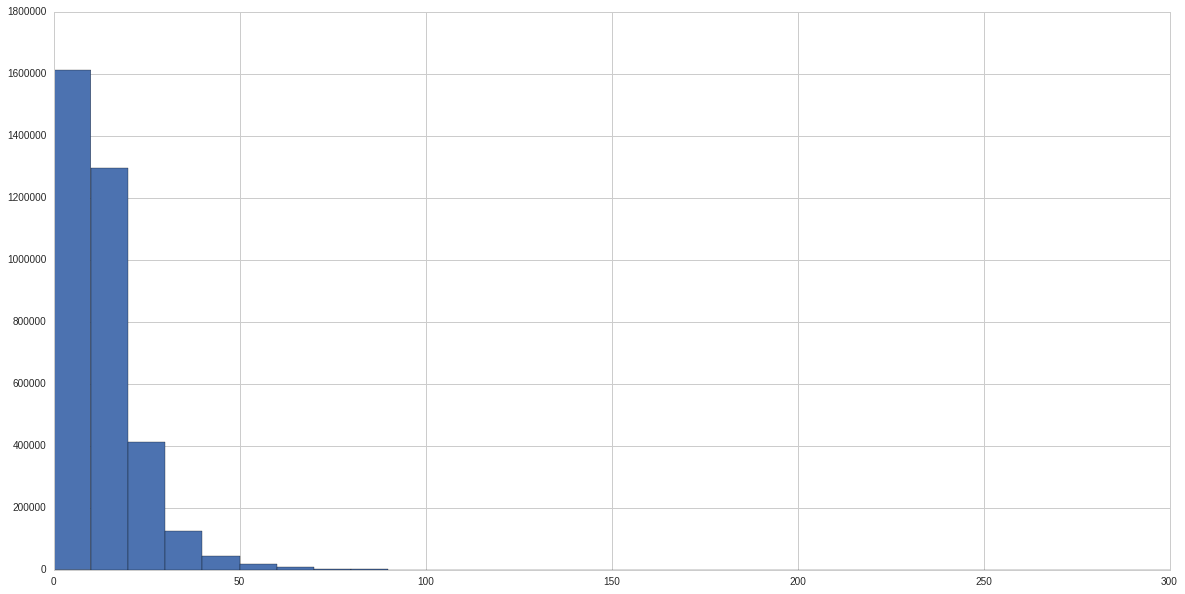

In [20]:
plt.hist(data['trip_time'] / np.timedelta64(1, 'm'), bins=30, range=[0, 300])
#plt.yscale('log')

In [21]:
len(data.trip_time.value_counts().values)

5840

That many unique values do we have in trip_time.

Identify the the cases without geo data and remove them from our data to be processed.

In [22]:
anomaly = data.loc[(data['dropoff_longitude'].isnull()) | (data['dropoff_latitude'].isnull()) | 
                       (data['pickup_longitude'].isnull()) | (data['pickup_latitude'].isnull())]
data = data.drop(anomaly.index)

In [23]:
anomaly['flag'] = 'geo_NA'

In [24]:
data.isnull().sum()

pickup_datetime            0
dropoff_datetime           0
passenger_count           12
trip_distance          32873
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
fare_amount                0
tip_amount           1656902
total_amount               0
trip_time               3864
dtype: int64

So how many percent of data are left to be processed?

In [25]:
len(data)/(len(data)+len(anomaly))

0.981279805082962

In [26]:
anomaly.tail()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,trip_time,flag
3534421,2013-05-12 23:58:56,2013-05-13 00:05:43,1.0,2.0,NaN,NaN,NaN,NaN,8.0,1.8,10.8,00:06:47,geo_NA
3534518,2013-05-12 23:59:02,2013-05-13 00:16:03,3.0,6.1,NaN,NaN,NaN,NaN,15.0,NaN,16.0,00:17:01,geo_NA
3534615,2013-05-12 23:59:52,2013-05-13 00:23:15,1.0,5.4,NaN,NaN,NaN,NaN,20.5,NaN,21.5,00:23:23,geo_NA
3534618,2013-05-12 23:59:54,2013-05-13 00:07:45,1.0,1.8,NaN,NaN,NaN,NaN,8.0,NaN,9.0,00:07:51,geo_NA
3534623,2013-05-12 23:59:56,2013-05-13 00:14:28,1.0,7.6,NaN,NaN,NaN,NaN,23.0,NaN,24.0,00:14:32,geo_NA


# <font color = 'blue'> So we only dropped 2% of the data because of missing geo tags. Someone could search the 'anomaly'-data for patterns, e.g. for fraud detection. We are also going to drop all the unrecognized trip_distances because we cannot (exactly) generate them (an approximation would be possible). </font color>

In [27]:
#taxidata.loc[(taxidata['trip_distance'].isnull())]
#print(len(anomaly))
anomaly = anomaly.append(data.loc[(data['trip_distance'].isnull())])
anomaly.loc[data.loc[(data['trip_distance'].isnull())].index,'flag'] = 'trip_dist_NA'
anomaly.tail()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,flag,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time
3534334,2013-05-13 00:03:12,40.749736,-73.978713,5.5,trip_dist_NA,1.0,2013-05-12 23:58:16,40.754459,-73.964803,NaN,6.5,NaN,00:04:56
3534517,2013-05-13 00:13:53,40.690212,-73.978735,14.0,trip_dist_NA,1.0,2013-05-12 23:59:01,40.733297,-73.987381,NaN,15.0,NaN,00:14:52
3534607,2013-05-13 00:05:02,40.744680,-73.999020,6.0,trip_dist_NA,1.0,2013-05-12 23:59:50,40.733435,-74.002994,NaN,7.0,NaN,00:05:12
3534612,2013-05-13 00:09:30,40.706187,-74.013075,9.5,trip_dist_NA,1.0,2013-05-12 23:59:52,40.729327,-73.992207,NaN,10.5,NaN,00:09:38
3534626,2013-05-13 00:00:28,40.757354,-73.967262,58.0,trip_dist_NA,1.0,2013-05-12 23:59:58,40.757354,-73.967262,11.6,69.6,NaN,00:00:30


In [28]:
data = data.drop(anomaly.index, errors='ignore') # ignore uncontained labels

In [29]:
data.isnull().sum()

pickup_datetime            0
dropoff_datetime           0
passenger_count            9
trip_distance              0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
fare_amount                0
tip_amount           1638285
total_amount               0
trip_time               2922
dtype: int64

In [30]:
1-len(data)/(len(data)+len(anomaly))

0.028020455877726502

# Drop all the columns with trip_time.isnull() 

In [31]:
anomaly = anomaly.append(data.loc[(data['trip_time'].isnull())])
anomaly.loc[data.loc[(data['trip_time'].isnull())].index,'flag'] = 'trip_time_NA'
anomaly.tail()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,flag,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time
3525186,2013-05-12 23:22:39,40.763210,-73.962524,7.0,trip_time_NA,1.0,2013-05-12 23:22:39,40.759930,-73.975325,NaN,8.0,1.30,NaT
3529613,2013-05-12 23:38:46,40.734109,-73.983598,5.0,trip_time_NA,1.0,2013-05-12 23:38:46,40.742107,-73.974624,1.2,7.2,1.00,NaT
3530873,2013-05-12 23:43:59,40.643328,-73.950397,34.0,trip_time_NA,1.0,2013-05-12 23:43:59,40.727880,-74.001728,NaN,35.0,9.90,NaT
3531118,2013-05-12 23:45:00,40.755222,-73.928660,3.0,trip_time_NA,1.0,2013-05-12 23:45:00,40.753865,-73.929723,NaN,4.0,0.15,NaT
3531331,2013-05-12 23:45:56,40.773872,-73.948701,5.5,trip_time_NA,1.0,2013-05-12 23:45:56,40.766625,-73.962938,NaN,6.5,1.20,NaT


In [32]:
data = data.drop(anomaly.index, errors='ignore') # ignore uncontained labels

# This is quite unreasonable. We have dropoff_datetime = pickup_datetime and the geo-coords of pickup and dropoff do not match! trip_time equals NaT here.

In [33]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
passenger_count,3.43266e+06,1.71448,1.38599,1,1,1,2,6
trip_distance,3.43267e+06,2.91113,3.34836,0.01,1.09,1.8,3.21,100
pickup_longitude,3.43267e+06,-73.9154,2.68755,-736.5,-73.9925,-73.9821,-73.968,40.8679
pickup_latitude,3.43267e+06,40.6919,2.91217,-74.0378,40.7365,40.7534,40.7679,2047.45
dropoff_longitude,3.43267e+06,-73.913,2.98107,-740.173,-73.9918,-73.9806,-73.9651,2387
dropoff_latitude,3.43267e+06,40.6899,3.43265,-3084.28,40.7353,40.7538,40.7686,473.982
fare_amount,3.43267e+06,12.4022,9.71666,2.5,6.5,9.5,14.5,382.75
tip_amount,1.79648e+06,2.59194,2.29176,0.01,1.3,2,3,155.5
total_amount,3.43267e+06,14.834,11.7278,2.5,8,11.3,16.7,382.76
trip_time,3432668,0 days 00:13:02.243506,0 days 00:27:26.535018,0 days 00:00:01,0 days 00:06:24,0 days 00:10:34,0 days 00:16:50,11 days 00:45:28


(array([  4.14860000e+04,   2.47244000e+05,   4.11413000e+05,
          4.47479000e+05,   4.18108000e+05,   3.64416000e+05,
          3.02291000e+05,   2.45960000e+05,   1.96811000e+05,
          1.57134000e+05,   1.23172000e+05,   9.75690000e+04,
          7.55190000e+04,   5.99140000e+04,   4.69780000e+04,
          3.66970000e+04,   2.90370000e+04,   2.32160000e+04,
          1.81990000e+04,   1.47690000e+04,   1.18490000e+04,
          9.75400000e+03,   7.90100000e+03,   6.83100000e+03,
          5.64600000e+03,   4.78400000e+03,   4.11200000e+03,
          3.75100000e+03,   3.13700000e+03,   2.76200000e+03,
          2.28500000e+03,   1.89500000e+03,   1.59500000e+03,
          1.43000000e+03,   1.15200000e+03,   1.03000000e+03,
          8.11000000e+02,   7.01000000e+02,   5.63000000e+02,
          4.33000000e+02,   3.88000000e+02,   3.50000000e+02,
          2.88000000e+02,   2.23000000e+02,   2.36000000e+02,
          1.84000000e+02,   1.59000000e+02,   1.33000000e+02,
        

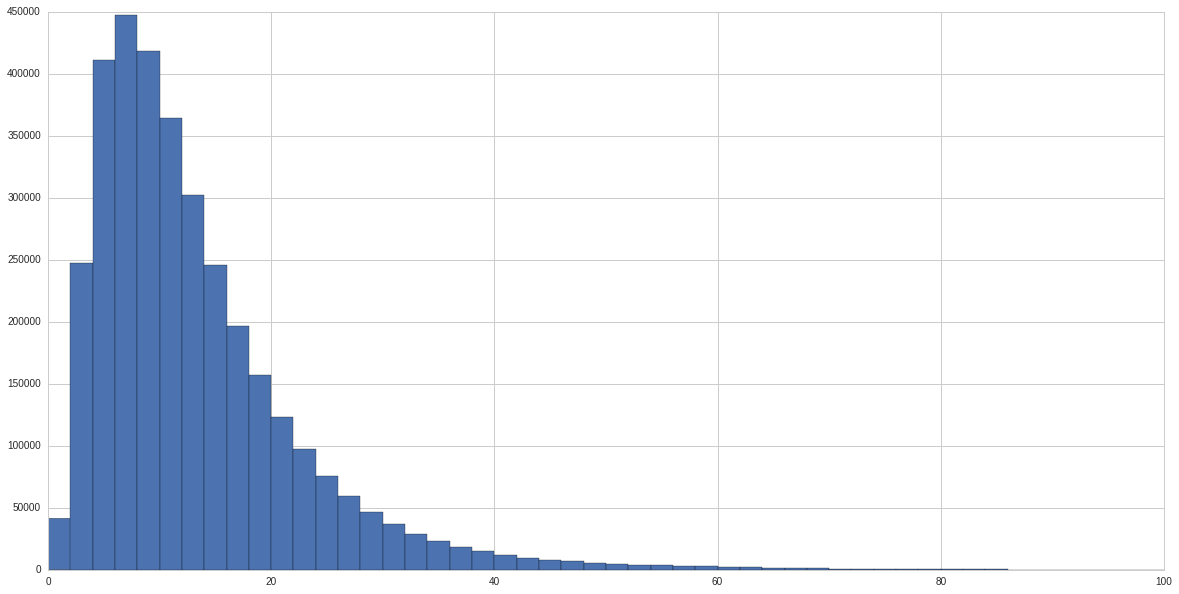

In [34]:
plt.hist(data.trip_time.values / np.timedelta64(1, 'm'), bins=50, range=[0,100])

In [35]:
print(data.trip_time.describe())
np.percentile(data.trip_time, [1,5,10,15,25,50,75,85,95,99]) / np.timedelta64(1,'m')

count                   3432668
mean     0 days 00:13:02.243506
std      0 days 00:27:26.535018
min             0 days 00:00:01
25%             0 days 00:06:24
50%             0 days 00:10:34
75%             0 days 00:16:50
max            11 days 00:45:28
Name: trip_time, dtype: object


array([  1.7945    ,   3.        ,   4.        ,   5.        ,
         6.4       ,  10.56666667,  16.83333333,  21.        ,
        31.        ,  49.08883333])

# We sometimes have some unreasonably small trip_times.

In [36]:
anomaly.tail()

,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,flag,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time
3525186,2013-05-12 23:22:39,40.763210,-73.962524,7.0,trip_time_NA,1.0,2013-05-12 23:22:39,40.759930,-73.975325,NaN,8.0,1.30,NaT
3529613,2013-05-12 23:38:46,40.734109,-73.983598,5.0,trip_time_NA,1.0,2013-05-12 23:38:46,40.742107,-73.974624,1.2,7.2,1.00,NaT
3530873,2013-05-12 23:43:59,40.643328,-73.950397,34.0,trip_time_NA,1.0,2013-05-12 23:43:59,40.727880,-74.001728,NaN,35.0,9.90,NaT
3531118,2013-05-12 23:45:00,40.755222,-73.928660,3.0,trip_time_NA,1.0,2013-05-12 23:45:00,40.753865,-73.929723,NaN,4.0,0.15,NaT
3531331,2013-05-12 23:45:56,40.773872,-73.948701,5.5,trip_time_NA,1.0,2013-05-12 23:45:56,40.766625,-73.962938,NaN,6.5,1.20,NaT


In [37]:
1-len(data)/(len(data)+len(anomaly))

0.028847133166903904

# <font color = 'blue'> So all in all, we dropped less than 3% of the data. </font color>

In [38]:
data.isnull().sum()

pickup_datetime            0
dropoff_datetime           0
passenger_count            9
trip_distance              0
pickup_longitude           0
pickup_latitude            0
dropoff_longitude          0
dropoff_latitude           0
fare_amount                0
tip_amount           1636185
total_amount               0
trip_time                  0
dtype: int64

# We can deal with that. External investigation of the anomaly is recommended.

# Start validating the non-anomaly data: Valid trip_time, valid distance?

Correct the avg amount for the initial charge. 

In [39]:
data['avg_amount_per_minute'] = (data.fare_amount-2.5) / (data.trip_time / np.timedelta64(1,'m'))

In [40]:
data.avg_amount_per_minute.describe()

count    3.432668e+06
mean     7.865239e-01
std      6.410160e+00
min      0.000000e+00
25%      5.769231e-01
50%      6.629834e-01
75%      7.857143e-01
max      6.450000e+03
Name: avg_amount_per_minute, dtype: float64

Min:0.0
Max:6450.0


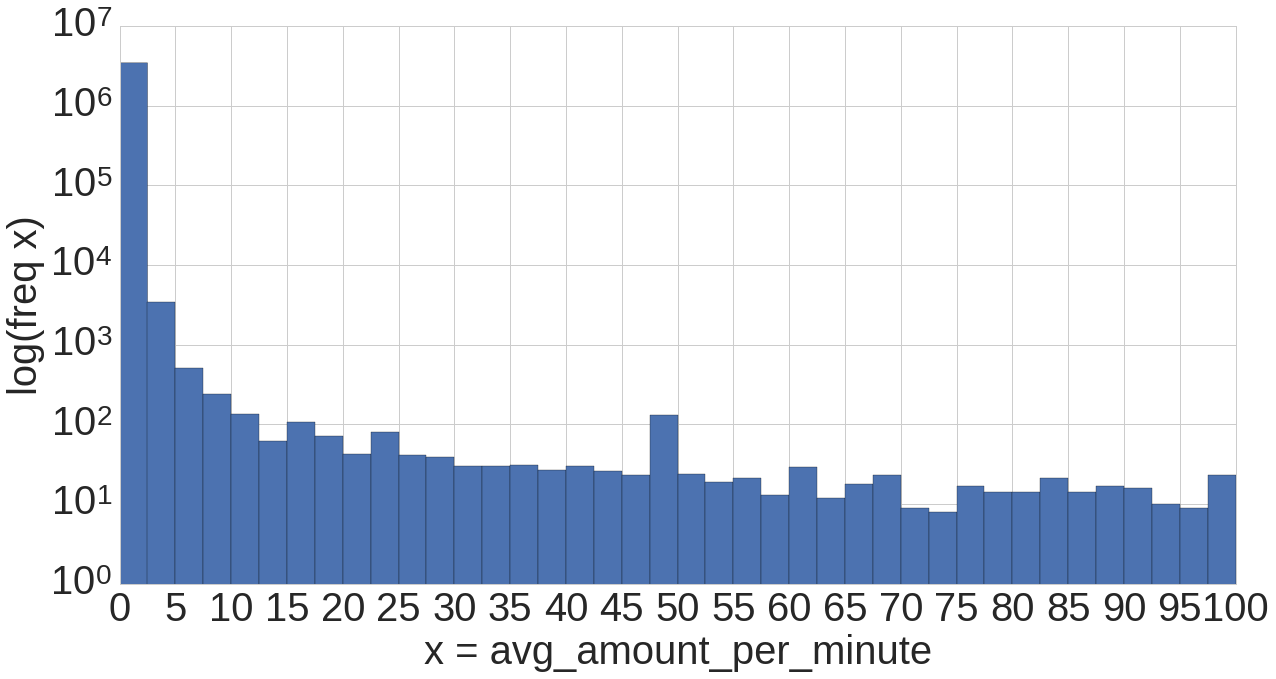

In [41]:
h = data.avg_amount_per_minute
plt.figure(figsize=(20,10))
plt.hist(h, normed=False, stacked=True, bins=40, range=[0 , 100], )
    #, histtype='stepfilled')
plt.yscale('log')
plt.ylabel('log(freq x)', fontsize=40)
plt.xlabel('x = avg_amount_per_minute', fontsize=40)
print('Min:' +  str(min(h)) + '\nMax:' +  str(max(h)))
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
plt.locator_params(axis = 'x', nbins = 20)
plt.show()

In [42]:
data.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,trip_time,avg_amount_per_minute
0,2013-05-06,2013-05-06 00:10:00,1.0,2.65,-73.981070,40.766047,-73.981362,40.738092,10.5,2.20,13.70,00:10:00,0.800000
1,2013-05-06,2013-05-06 00:06:00,5.0,1.86,-73.986312,40.760487,-74.005082,40.743372,7.5,NaN,8.50,00:06:00,0.833333
2,2013-05-06,2013-05-06 00:04:00,1.0,0.90,-73.989388,40.731577,-73.986102,40.740732,5.5,NaN,6.50,00:04:00,0.750000
3,2013-05-06,2013-05-06 00:08:00,1.0,2.59,-73.994590,40.751857,-73.963470,40.765912,9.5,NaN,10.50,00:08:00,0.875000
4,2013-05-06,2013-05-06 00:29:00,1.0,18.26,-73.783327,40.648510,-73.974808,40.624810,51.5,6.75,59.25,00:29:00,1.689655


In [43]:
data.avg_amount_per_minute.quantile([.0001,.01, .5, .75, .95, .975, .99, .995])

0.0001    0.000000
0.0100    0.437318
0.5000    0.662983
0.7500    0.785714
0.9500    1.151163
0.9750    1.344677
0.9900    1.605263
0.9950    1.847222
Name: avg_amount_per_minute, dtype: float64

# Compare to http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml . We have a strict lower bound with .5 \$ per minute (taxi waiting in congestion). 2.5 \$ per minute match roughly 1 miles / minute (no static fares included!). So the taxi would drive 60 mp/h.  We take this as an upper bound.

In [44]:
lb = 0.5
ub = 2.5
anomaly = anomaly.append(data.loc[(data['avg_amount_per_minute'] > ub) | (data['avg_amount_per_minute'] < lb)])
#anomaly.loc[
anomaly.loc[data.loc[(data['avg_amount_per_minute'] > ub)].index,'flag'] = 'too fast'
anomaly.loc[data.loc[(data['avg_amount_per_minute'] < lb)].index,'flag'] = 'too slow'
data = data.drop(anomaly.index, errors='ignore') # ignore uncontained labels / indices
print(1-len(data)/(len(data)+len(anomaly)))

0.06037092404527544


So we dropped around 6% of the data.

In [45]:
data.avg_amount_per_minute.describe()

count    3.321243e+06
mean     7.244103e-01
std      2.173654e-01
min      5.000000e-01
25%      5.833333e-01
50%      6.666667e-01
75%      7.916667e-01
max      2.500000e+00
Name: avg_amount_per_minute, dtype: float64

In [46]:
anomaly.tail()

,avg_amount_per_minute,dropoff_datetime,dropoff_latitude,dropoff_longitude,fare_amount,flag,passenger_count,pickup_datetime,pickup_latitude,pickup_longitude,tip_amount,total_amount,trip_distance,trip_time
3534347,3.571429,2013-05-13 00:17:15,40.721621,-74.033262,70.0,too fast,1.0,2013-05-12 23:58:21,40.725023,-74.007006,2.00,80.25,3.40,00:18:54
3534376,297.000000,2013-05-12 23:58:46,40.761277,-73.993425,52.0,too fast,1.0,2013-05-12 23:58:36,40.761278,-73.993303,11.55,69.38,0.90,00:00:10
3534378,0.410959,2013-05-13 00:07:08,40.724592,-73.981777,6.0,too slow,1.0,2013-05-12 23:58:37,40.735385,-73.991185,1.40,8.40,1.10,00:08:31
3534514,2.605263,2013-05-13 00:18:00,40.792230,-73.946103,52.0,too fast,1.0,2013-05-12 23:59:00,40.666372,-73.793397,10.40,68.23,16.11,00:19:00
3534548,9.110429,2013-05-13 00:04:42,40.755859,-73.972549,52.0,too fast,1.0,2013-05-12 23:59:16,40.740766,-73.944841,11.56,69.39,2.50,00:05:26


# <font color = 'red' > Drop even more columns (e.g. tip)? </font color>

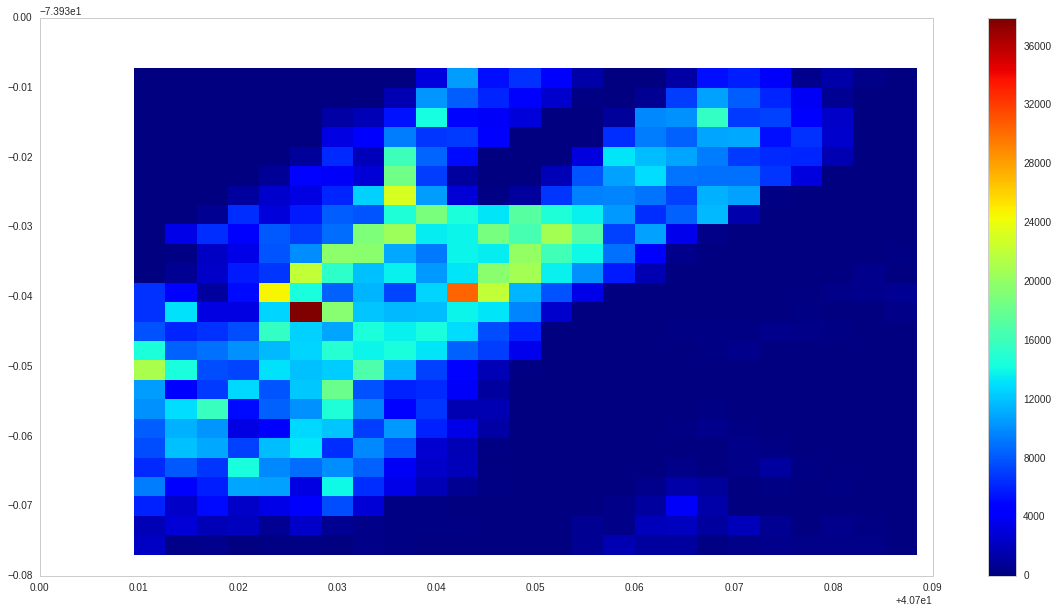

In [47]:
x = data.pickup_latitude
y = data.pickup_longitude

H, xedges, yedges = np.histogram2d(x, y, bins=25, range=[ [x.quantile(.05), x.quantile(.95)], 
        [y.quantile(.05), y.quantile(.95)]], normed=False, weights=None)

plt.jet()
fig = plt.figure(figsize=(20, 10))
#ax.set_title('pcolormesh: exact bin edges')
X, Y = np.meshgrid(xedges, yedges)
mesh = plt.pcolormesh(X, Y, H)
plt.colorbar(mesh)
#ax.set_aspect('equal')
#plt.savefig('figure.pdf', format='pdf')
#plt.savefig('figure.png', format='png')

In [48]:
type(H)

numpy.ndarray

In [49]:
print(H.shape)
print(H.size)
print(H.max())

(25, 25)
625
37933.0


In [50]:
print(xedges.shape)
xedges[0]

(26,)


40.709567

In [51]:
print(xedges)
print(yedges)

[ 40.709567  40.71272   40.715873  40.719026  40.722179  40.725332
  40.728485  40.731638  40.734791  40.737944  40.741097  40.74425
  40.747403  40.750556  40.753709  40.756862  40.760015  40.763168
  40.766321  40.769474  40.772627  40.77578   40.778933  40.782086
  40.785239  40.788392]
[-74.0069   -74.004115 -74.00133  -73.998545 -73.99576  -73.992975
 -73.99019  -73.987405 -73.98462  -73.981835 -73.97905  -73.976265
 -73.97348  -73.970695 -73.96791  -73.965125 -73.96234  -73.959555
 -73.95677  -73.953985 -73.9512   -73.948415 -73.94563  -73.942845
 -73.94006  -73.937275]


In [52]:
from geopy.distance import vincenty
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(vincenty(newport_ri, cleveland_oh).miles)
#538.3904451566326

538.3904451566326


In [53]:
print('Current bin width:')
print(vincenty((xedges[0], yedges[0]), (xedges[1], yedges[1])).meters)

Current bin width:
421.87442874986147


In [54]:
distances = (-1)*np.ones(len(xedges)-1)
for x in range(0,len(xedges)-1, 1):
    distances[x] = vincenty((xedges[x], yedges[x]), (xedges[x+1], yedges[x+1])).meters

In [55]:
print('Sizes of all bins in meters:')
distances

Sizes of all bins in meters:


array([ 421.87442875,  421.86839554,  421.86236213,  421.85632854,
        421.85029475,  421.84426078,  421.83822661,  421.83219225,
        421.82615771,  421.82012297,  421.81408804,  421.80805293,
        421.80201762,  421.79598212,  421.78994644,  421.78391056,
        421.77787449,  421.77183824,  421.76580179,  421.75976516,
        421.75372833,  421.74769132,  421.74165411,  421.73561672,
        421.72957914])

In [56]:
print(str(max(data.pickup_latitude)) +','+ str(max(data.pickup_longitude)))
print(str(max(data.dropoff_latitude)) +','+ str(max(data.dropoff_longitude)))

2047.45495,40.867882
473.981648,2386.995232


# What is going on here? Surprising values in lon/lat?

# Only look at trips in a given bounding box


In [57]:
jfk_geodata = (40.641547, -73.778118)
ridgefield_geodata = (40.856406, -74.020642)
data_in_box = data.loc[(data['dropoff_latitude'] > jfk_geodata[0]) & 
                       (data['dropoff_longitude'] < jfk_geodata[1]) &
                       (data['dropoff_latitude'] < ridgefield_geodata[0]) & 
                       (data['dropoff_longitude'] > ridgefield_geodata[1]) & 
                       (data['pickup_latitude'] > jfk_geodata[0]) & 
                       (data['pickup_longitude'] < jfk_geodata[1]) &
                       (data['pickup_latitude'] < ridgefield_geodata[0]) & 
                       (data['pickup_longitude'] > ridgefield_geodata[1])         
                       ]
# taxidata = taxidata.drop(anomaly.index)

<font color = 'red'> Be careful! They use negative (lat, long), not East/West! </font color>

In [58]:
data_in_box.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,trip_time,avg_amount_per_minute
0,2013-05-06,2013-05-06 00:10:00,1.0,2.65,-73.981070,40.766047,-73.981362,40.738092,10.5,2.2,13.7,00:10:00,0.800000
1,2013-05-06,2013-05-06 00:06:00,5.0,1.86,-73.986312,40.760487,-74.005082,40.743372,7.5,NaN,8.5,00:06:00,0.833333
2,2013-05-06,2013-05-06 00:04:00,1.0,0.90,-73.989388,40.731577,-73.986102,40.740732,5.5,NaN,6.5,00:04:00,0.750000
3,2013-05-06,2013-05-06 00:08:00,1.0,2.59,-73.994590,40.751857,-73.963470,40.765912,9.5,NaN,10.5,00:08:00,0.875000
5,2013-05-06,2013-05-06 00:14:00,3.0,4.86,-73.965532,40.717052,-73.972442,40.743247,16.5,NaN,17.5,00:14:00,1.000000


In [59]:
jfk_geodata < ridgefield_geodata
len(data_in_box)/len(data)

0.9834670332763968

So we've omitted about 2% of the data because the trips do not start and end in the box

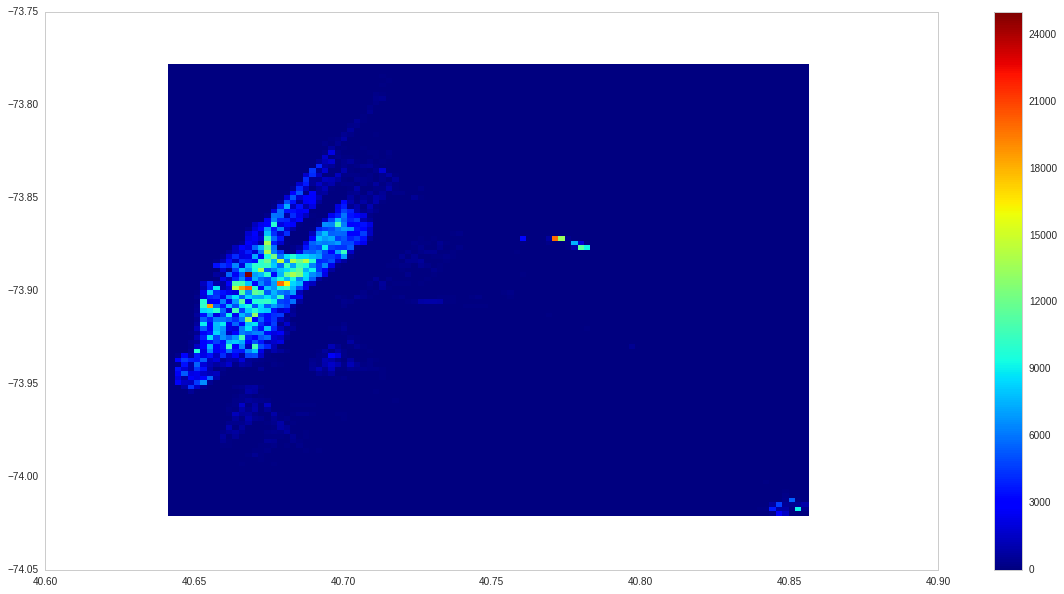

In [60]:
x = data_in_box.pickup_latitude
y = data_in_box.pickup_longitude

H, xedges, yedges = np.histogram2d(x, y, bins=100, normed=False, weights=None)

plt.jet()
fig = plt.figure(figsize=(20, 10))
#ax.set_title('pcolormesh: exact bin edges')
X, Y = np.meshgrid(xedges, yedges)
mesh = plt.pcolormesh(X, Y, H)
plt.colorbar(mesh)
#ax.set_aspect('equal')
#plt.savefig('figure.pdf', format='pdf')
#plt.savefig('figure.png', format='png')

In [61]:
print(H.shape)
print(H.size)
print(H.max())
print(xedges.shape)
print(xedges)
print(yedges)

distances = (-1)*np.ones(len(xedges)-1)
for x in range(0,len(xedges)-1, 1):
    distances[x] = vincenty((xedges[x], yedges[x]), (xedges[x+1], yedges[x+1])).meters
    
print('Sizes of all bins in meters:')
distances

(100, 100)
10000
25011.0
(101,)
[ 40.641548    40.64369611  40.64584422  40.64799233  40.65014044
  40.65228855  40.65443666  40.65658477  40.65873288  40.66088099
  40.6630291   40.66517721  40.66732532  40.66947343  40.67162154
  40.67376965  40.67591776  40.67806587  40.68021398  40.68236209
  40.6845102   40.68665831  40.68880642  40.69095453  40.69310264
  40.69525075  40.69739886  40.69954697  40.70169508  40.70384319
  40.7059913   40.70813941  40.71028752  40.71243563  40.71458374
  40.71673185  40.71887996  40.72102807  40.72317618  40.72532429
  40.7274724   40.72962051  40.73176862  40.73391673  40.73606484
  40.73821295  40.74036106  40.74250917  40.74465728  40.74680539
  40.7489535   40.75110161  40.75324972  40.75539783  40.75754594
  40.75969405  40.76184216  40.76399027  40.76613838  40.76828649
  40.7704346   40.77258271  40.77473082  40.77687893  40.77902704
  40.78117515  40.78332326  40.78547137  40.78761948  40.78976759
  40.7919157   40.79406381  40.79621192  40.

array([ 314.61402538,  314.609805  ,  314.6055845 ,  314.6013639 ,
        314.59714319,  314.59292237,  314.58870145,  314.58448042,
        314.58025928,  314.57603803,  314.57181668,  314.56759522,
        314.56337366,  314.55915198,  314.5549302 ,  314.55070832,
        314.54648632,  314.54226422,  314.53804202,  314.5338197 ,
        314.52959728,  314.52537475,  314.52115212,  314.51692937,
        314.51270653,  314.50848357,  314.50426051,  314.50003734,
        314.49581407,  314.49159069,  314.4873672 ,  314.4831436 ,
        314.4789199 ,  314.47469609,  314.47047218,  314.46624816,
        314.46202403,  314.4577998 ,  314.45357545,  314.44935101,
        314.44512645,  314.44090179,  314.43667703,  314.43245216,
        314.42822718,  314.42400209,  314.4197769 ,  314.4155516 ,
        314.4113262 ,  314.40710069,  314.40287507,  314.39864935,
        314.39442352,  314.39019758,  314.38597154,  314.38174539,
        314.37751914,  314.37329278,  314.36906631,  314.36483

In [62]:
(H==0).sum()/H.size

0.55589999999999995

# So we know that 55% of the bins have 0 pickups in it.

## Let's take a first look at the distribution if the target variable which we want to estimate:

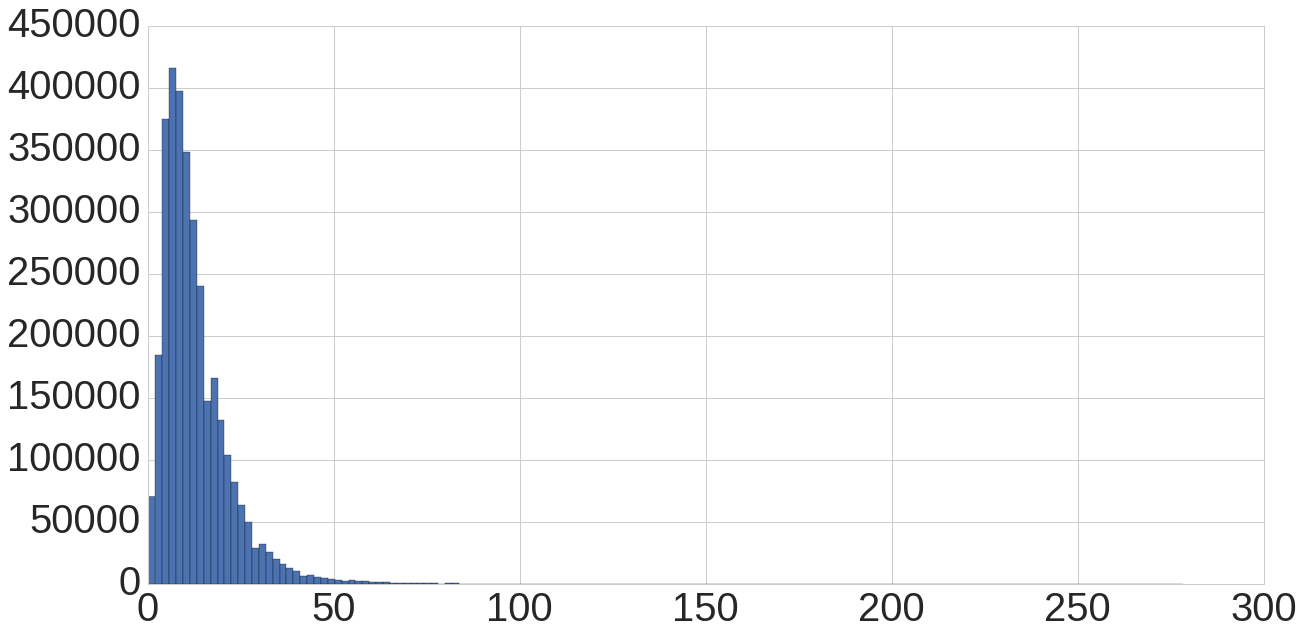

In [63]:
h = data_in_box.trip_time.values / np.timedelta64(1, 'm')
plt.figure(figsize=(20,10))
plt.hist(h, normed=False,  bins=150)
    #, histtype='stepfilled')
#plt.yscale('log')
#plt.ylabel('log(freq x)', fontsize=40)
#plt.xlabel('x = avg_amount_per_minute', fontsize=40)
#print('Min:' +  str(min(h)) + '\nMax:' +  str(max(h)))
plt.yticks(fontsize=40)
plt.xticks(fontsize=40)
#plt.locator_params(axis = 'x', nbins = 20)
plt.show()

In [64]:
data_in_box.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,tip_amount,total_amount,trip_time,avg_amount_per_minute
0,2013-05-06,2013-05-06 00:10:00,1.0,2.65,-73.981070,40.766047,-73.981362,40.738092,10.5,2.2,13.7,00:10:00,0.800000
1,2013-05-06,2013-05-06 00:06:00,5.0,1.86,-73.986312,40.760487,-74.005082,40.743372,7.5,NaN,8.5,00:06:00,0.833333
2,2013-05-06,2013-05-06 00:04:00,1.0,0.90,-73.989388,40.731577,-73.986102,40.740732,5.5,NaN,6.5,00:04:00,0.750000
3,2013-05-06,2013-05-06 00:08:00,1.0,2.59,-73.994590,40.751857,-73.963470,40.765912,9.5,NaN,10.5,00:08:00,0.875000
5,2013-05-06,2013-05-06 00:14:00,3.0,4.86,-73.965532,40.717052,-73.972442,40.743247,16.5,NaN,17.5,00:14:00,1.000000


In [65]:
#data_in_box['pickup_datetime'].dt.dayofweek
#tdata_in_box['pickup_datetime'].dt.hourb
#data_in_box['pickup_datetime'].dt.month # year, month, day, hour, minute, second, microsecond, and tzinfo.
#data_in_box['pickup_datetime'].dt.day

# Make a new dataframe with features and targets to train the model

In [66]:
time_regression_df = pd.DataFrame([#data_in_box['pickup_datetime'].dt.day,
                          data_in_box['pickup_datetime'].dt.dayofweek,
                          data_in_box['pickup_datetime'].dt.hour,
                          data_in_box['pickup_latitude'],
                          data_in_box['pickup_longitude'],
                          data_in_box['dropoff_latitude'],
                          data_in_box['dropoff_longitude'],
                          np.ceil(data_in_box['trip_time']/np.timedelta64(1, 'm')),
                         ]).T

In [67]:
time_regression_df.columns = [#'pickup_datetime_day', 
                                 'pickup_datetime_dayofweek', 'pickup_datetime_hour',
                                 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude',
                                 'trip_time_in_mins']

Use minutes for prediction instead of seconds (ceil the time). Definitley more robust than seconds!

In [68]:
time_regression_df.tail()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_time_in_mins
3534627,6.0,23.0,40.744021,-73.999512,40.825470,-73.953479,15.0
3534628,6.0,23.0,40.741475,-73.981322,40.751637,-73.975838,3.0
3534629,6.0,23.0,40.770077,-73.863887,40.644504,-73.963537,22.0
3534630,6.0,23.0,40.736240,-73.990593,40.744194,-73.985401,5.0
3534631,6.0,23.0,40.772929,-73.949516,40.728967,-73.988787,15.0


In [69]:
time_regression_df.head()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_time_in_mins
0,0.0,0.0,40.766047,-73.981070,40.738092,-73.981362,10.0
1,0.0,0.0,40.760487,-73.986312,40.743372,-74.005082,6.0
2,0.0,0.0,40.731577,-73.989388,40.740732,-73.986102,4.0
3,0.0,0.0,40.751857,-73.994590,40.765912,-73.963470,8.0
5,0.0,0.0,40.717052,-73.965532,40.743247,-73.972442,14.0


In [70]:
time_regression_df.ix[:,0:6].describe()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
count,3.266333e+06,3.266333e+06,3.266333e+06,3.266333e+06,3.266333e+06,3.266333e+06
mean,3.039328e+00,1.350386e+01,4.075136e+01,-7.397645e+01,4.075162e+01,-7.397513e+01
std,1.961083e+00,6.552920e+00,2.582007e-02,3.135320e-02,2.840570e-02,3.012289e-02
min,0.000000e+00,0.000000e+00,4.064155e+01,-7.402063e+01,4.064155e+01,-7.402057e+01
25%,1.000000e+00,9.000000e+00,4.073668e+01,-7.399259e+01,4.073577e+01,-7.399176e+01
50%,3.000000e+00,1.400000e+01,4.075343e+01,-7.398216e+01,4.075387e+01,-7.398066e+01
75%,5.000000e+00,1.900000e+01,4.076813e+01,-7.396825e+01,4.076884e+01,-7.396539e+01
max,6.000000e+00,2.300000e+01,4.085636e+01,-7.377812e+01,4.085640e+01,-7.377812e+01


In [71]:
print(time_regression_df.trip_time_in_mins.value_counts())
print(len(time_regression_df.trip_time_in_mins.value_counts()))

7.0      216659
6.0      212922
8.0      212253
9.0      203203
5.0      198847
10.0     190577
11.0     176963
4.0      167658
12.0     161870
13.0     146481
14.0     132243
15.0     118781
3.0      115848
16.0     106682
17.0      94945
18.0      84644
19.0      75749
20.0      67035
21.0      58914
2.0       55534
22.0      52250
23.0      46464
24.0      40736
25.0      35394
26.0      31199
27.0      27649
28.0      24524
29.0      21292
30.0      18618
31.0      16680
          ...  
120.0         3
123.0         2
143.0         2
145.0         2
128.0         2
138.0         2
121.0         2
119.0         2
118.0         2
157.0         1
156.0         1
154.0         1
153.0         1
148.0         1
160.0         1
164.0         1
137.0         1
178.0         1
136.0         1
134.0         1
133.0         1
132.0         1
131.0         1
130.0         1
129.0         1
125.0         1
124.0         1
117.0         1
115.0         1
279.0         1
Name: trip_time_in_mins,

So we hace 148 different times to predict.

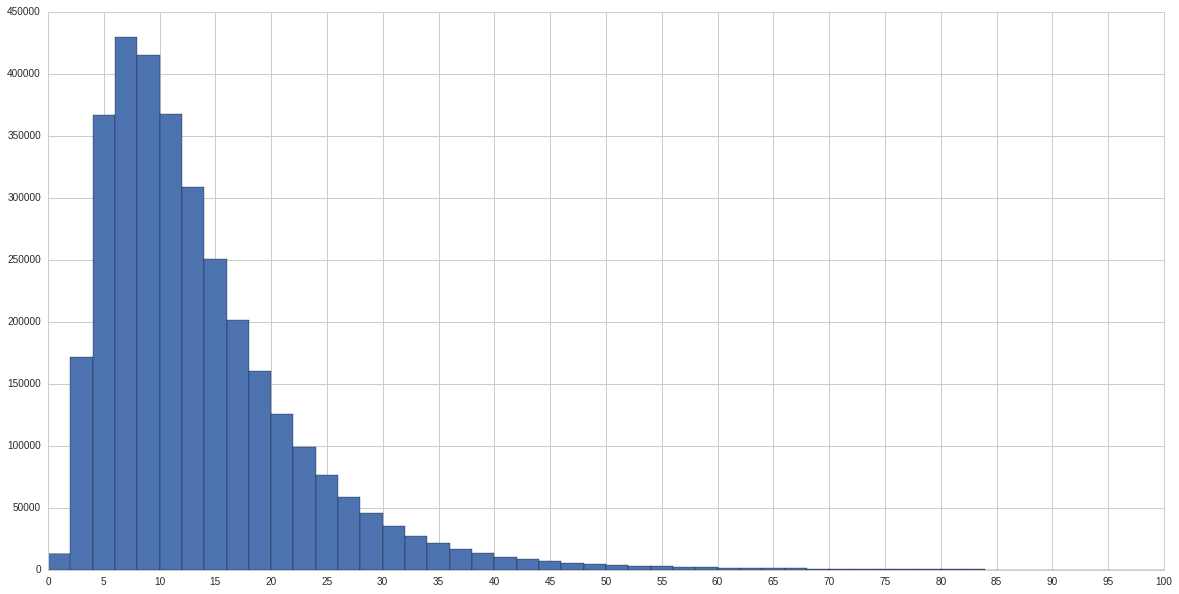

In [72]:
plt.hist(time_regression_df.trip_time_in_mins.values, bins=50, range = [0,100])
plt.locator_params(axis = 'x', nbins = 20)

In [73]:
time_regression_df.trip_time_in_mins.quantile([0.05, 0.95])

0.05     3.0
0.95    30.0
Name: trip_time_in_mins, dtype: float64

# Split the data into a training dataset and a test dataset. Evaluate the performance of the decision tree on the test data

In [74]:
hour_stats = time_regression_df.groupby(time_regression_df.pickup_datetime_hour)

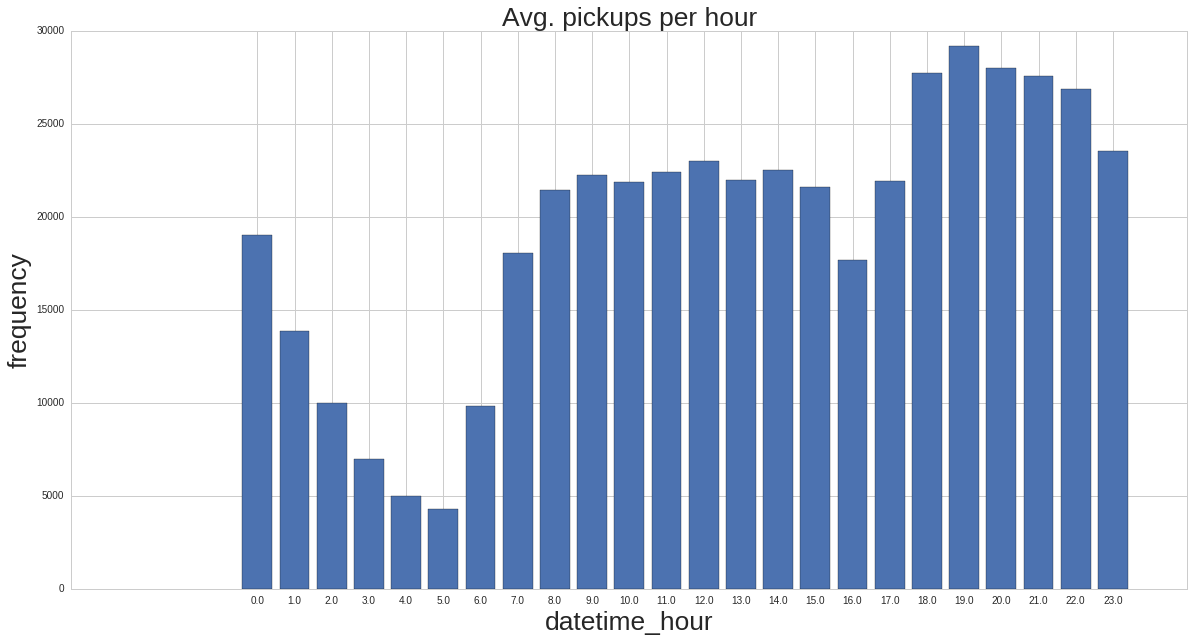

In [75]:
plt.bar(left = hour_stats.pickup_datetime_hour.count().keys(), height=hour_stats.pickup_datetime_hour.count().values/7, 
       tick_label=hour_stats.pickup_datetime_hour.count().keys(), align='center')
plt.title('Avg. pickups per hour')
plt.xlabel('datetime_hour')
plt.ylabel('frequency')
plt.savefig('avg_pickups_per_hour.png')

In [76]:
print('Avg. pickups per half-hour (summarized over 1 week)')
hour_stats.pickup_datetime_hour.count()/14

Avg. pickups per half-hour (summarized over 1 week)


pickup_datetime_hour
0.0      9498.000000
1.0      6936.000000
2.0      4986.357143
3.0      3496.357143
4.0      2482.285714
5.0      2151.500000
6.0      4909.357143
7.0      9031.214286
8.0     10726.285714
9.0     11130.571429
10.0    10944.857143
11.0    11205.857143
12.0    11487.642857
13.0    10997.642857
14.0    11269.785714
15.0    10798.785714
16.0     8841.285714
17.0    10963.857143
18.0    13860.857143
19.0    14584.714286
20.0    14010.142857
21.0    13788.142857
22.0    13446.642857
23.0    11761.357143
Name: pickup_datetime_hour, dtype: float64

In [84]:
(hour_stats.count()/14).quantile([.5])

,pickup_datetime_dayofweek,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_time_in_mins
0.5,10954.357143,10954.357143,10954.357143,10954.357143,10954.357143,10954.357143


(array([ 2.,  1.,  2.,  1.,  0.,  3.,  2.,  8.,  0.,  5.]),
 array([  2151.5       ,   3394.82142857,   4638.14285714,   5881.46428571,
          7124.78571429,   8368.10714286,   9611.42857143,  10854.75      ,
         12098.07142857,  13341.39285714,  14584.71428571]),
 <a list of 10 Patch objects>)

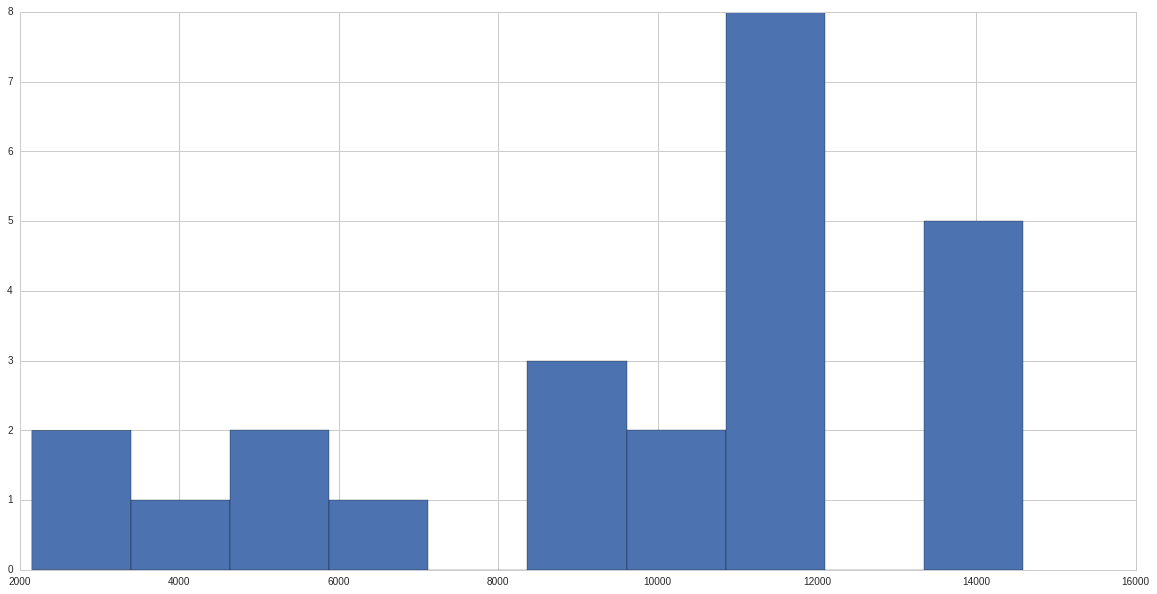

In [87]:
plt.hist(hour_stats.pickup_datetime_hour.count()/14)

In [88]:
hour_stats['pickup_datetime_dayofweek'].head()

0         0.0
1         0.0
2         0.0
3         0.0
5         0.0
12129     0.0
12130     0.0
12131     0.0
12132     0.0
12133     0.0
19711     0.0
19712     0.0
19713     0.0
19714     0.0
19715     0.0
23945     0.0
23946     0.0
23947     0.0
23948     0.0
23949     0.0
26968     0.0
26969     0.0
26970     0.0
26971     0.0
26972     0.0
30082     0.0
30083     0.0
30084     0.0
30085     0.0
30086     0.0
         ... 
309100    0.0
309101    0.0
309102    0.0
309103    0.0
309104    0.0
340232    0.0
340233    0.0
340234    0.0
340235    0.0
340236    0.0
370324    0.0
370325    0.0
370326    0.0
370327    0.0
370328    0.0
398331    0.0
398332    0.0
398333    0.0
398334    0.0
398335    0.0
425495    0.0
425496    0.0
425497    0.0
425498    0.0
425499    0.0
450242    0.0
450243    0.0
450244    0.0
450245    0.0
450246    0.0
Name: pickup_datetime_dayofweek, dtype: float64

In [75]:
from sklearn import cross_validation as cv
y = time_regression_df["trip_time_in_mins"]
X = time_regression_df.ix[:,0:6]
X_train, X_test, y_train, y_test = cv.train_test_split(X, y,test_size=0.1,random_state=0) 

In [76]:
X_test.head()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude
2972051,5.0,20.0,40.759390,-73.970105,40.787357,-73.970247
1357753,2.0,20.0,40.745082,-73.985037,40.735312,-73.987955
340293,0.0,19.0,40.721210,-74.008468,40.727780,-73.993192
1824941,3.0,18.0,40.819377,-73.951947,40.767631,-73.966563
1298476,2.0,18.0,40.800847,-73.967847,40.806457,-73.964812


In [77]:
y_test.head()

2972051    11.0
1357753    16.0
340293      9.0
1824941    22.0
1298476     3.0
Name: trip_time_in_mins, dtype: float64

In [78]:
Xy_test = pd.concat([X_test, y_test], axis=1)

In [79]:
Xy_test.head()

,pickup_datetime_dayofweek,pickup_datetime_hour,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_time_in_mins
2972051,5.0,20.0,40.759390,-73.970105,40.787357,-73.970247,11.0
1357753,2.0,20.0,40.745082,-73.985037,40.735312,-73.987955,16.0
340293,0.0,19.0,40.721210,-74.008468,40.727780,-73.993192,9.0
1824941,3.0,18.0,40.819377,-73.951947,40.767631,-73.966563,22.0
1298476,2.0,18.0,40.800847,-73.967847,40.806457,-73.964812,3.0


In [80]:
Xy_test.to_csv('taxi_tree_test_Xy_20130506-12.csv')
X_test.to_csv('taxi_tree_test_X_20130506-12.csv')
y_test.to_csv('taxi_tree_test_y_20130506-12.csv')

In [81]:
# Xy_test_sample = Xy_test.sample(10000, random_state=99)

In [82]:
# Xy_test_sample.to_csv('taxi_tree_test_Xy_sample.csv')

In [83]:
# Xy_test_sample.head()

In [84]:
print(X_train.shape)
print(X_train.size)
print(X_test.shape)
print(X.shape)
print(X_train.shape[0]+X_test.shape[0])

(2939699, 6)
17638194
(326634, 6)
(3266333, 6)
3266333


In [102]:
import time
t = time.time()

In [103]:
print(__doc__)

# Import the necessary modules and libraries
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt

#features = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude','pickup_datetime']
#print("* features:", features, sep="\n")


regtree = DecisionTreeRegressor(min_samples_split=3, random_state=99, max_depth=30)# formerly 15. 15 is reasonable, 
# 30 brings best results
                                                                                     # random states: 99
regtree.fit(X_train, y_train)




Automatically created module for IPython interactive environment


DecisionTreeRegressor(criterion='mse', max_depth=30, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, presort=False, random_state=99,
           splitter='best')

In [104]:
elapsed = time.time() - t
print(elapsed)

35.05194664001465


In [105]:
regtree.score(X_test, y_test)

0.62772305011083662

In [90]:
# do not export for depth = 30. It's too complex!
from sklearn import tree
tree.export_graphviz(regtree, out_file='figures/tree_d15.dot', feature_names=time_regression_df.ix[:,0:6].columns, class_names=time_regression_df.columns[6])    

In [149]:
print(regtree.tree_.feature)
print(regtree.tree_.children_left)
print(regtree.tree_.children_right)

[ 4  6  5 ..., -2 -2 -2]
[ 1  2  3 ..., -1 -1 -1]
[15818 12497  6154 ...,    -1    -1    -1]


Prepare a dictionary to look uop the features that are splitted in the nodes

In [150]:
feature_dict = {}
for i in range(0,7):
    feature_dict[i] = time_regression_df.ix[:,i].name
print(feature_dict)

{0: 'pickup_datetime_day', 1: 'pickup_datetime_dayofweek', 2: 'pickup_datetime_hour', 3: 'pickup_latitude', 4: 'pickup_longitude', 5: 'dropoff_latitude', 6: 'dropoff_longitude'}


In [97]:
feature_splits = list(regtree.tree_.feature)
for i in range(0,len(regtree.tree_.feature)):
    if feature_splits[i] >= 0:
        feature_splits[i] = feature_dict[feature_splits[i]]

In [98]:
print(feature_splits)
print(regtree.tree_.threshold)

['pickup_longitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_latitude', 'pickup_latitude', 'dropoff_longitude', 'pickup_longitude', 'dropoff_latitude', 'pickup_latitude', 'dropoff_latitude', -2, -2, 'dropoff_latitude', -2, -2, 'pickup_longitude', 'dropoff_longitude', -2, -2, 'pickup_latitude', -2, -2, 'dropoff_longitude', 'pickup_longitude', 'pickup_datetime_hour', -2, -2, 'pickup_datetime_day', -2, -2, 'dropoff_latitude', 'pickup_latitude', -2, -2, 'pickup_latitude', -2, -2, 'pickup_longitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_latitude', -2, -2, 'dropoff_longitude', -2, -2, 'dropoff_longitude', 'pickup_datetime_hour', -2, -2, 'pickup_datetime_hour', -2, -2, 'pickup_latitude', 'dropoff_longitude', 'pickup_latitude', -2, -2, 'pickup_longitude', -2, -2, 'dropoff_latitude', 'dropoff_latitude', -2, -2, 'dropoff_longitude', -2, -2, 'dropoff_latitude', 'dropoff_latitude', 'dropoff_longitude', 'pickup_datetime_hour', 'dropoff_latitude', -2, -2, 'dropoff_latitude', -2,

In [99]:
# from http://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree
def get_code(tree, feature_names):
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        print( "if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        print( "} else {")
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        print( "}")
                else:
                        print( "return " + str(value[node]))

        recurse(left, right, threshold, features, 0)

In [100]:
# from http://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree
def get_code_matrix(tree, feature_names):
        decision_list = []
        left      = tree.tree_.children_left
        right     = tree.tree_.children_right
        threshold = tree.tree_.threshold
        features  = [feature_names[i] for i in tree.tree_.feature]
        value = tree.tree_.value
        #frame =  pd.DataFrame(np.nan, columns=['leaf_no', range(1,tree.tree_.max_depth), 'value'])

        def recurse(left, right, threshold, features, node):
                if (threshold[node] != -2):
                        decision_list.append({str(features[node]):threshold[node]})
                        if left[node] != -1:
                                recurse (left, right, threshold, features,left[node])
                        decision_list.append({'back': -1})
                        if right[node] != -1:
                                recurse (left, right, threshold, features,right[node])
                        decision_list.append({'back': -1})
                else:
                        decision_list.append({'leaf_val':value[node][0][0]})

        recurse(left, right, threshold, features, 0) # root node
        return decision_list

In [101]:
a = get_code_matrix(regtree, feature_names=time_regression_df.ix[:,0:7].columns)

In [102]:
a[0:20]

[{'pickup_longitude': -73.886093139648438},
 {'dropoff_longitude': -73.876411437988281},
 {'dropoff_latitude': 40.711517333984375},
 {'pickup_latitude': 40.735557556152344},
 {'pickup_latitude': 40.721664428710938},
 {'dropoff_longitude': -73.984504699707031},
 {'pickup_longitude': -73.966636657714844},
 {'dropoff_latitude': 40.701427459716797},
 {'pickup_latitude': 40.703460693359375},
 {'dropoff_latitude': 40.652553558349609},
 {'leaf_val': 13.16988416988417},
 {'back': -1},
 {'leaf_val': 8.0531899219095333},
 {'back': -1},
 {'back': -1},
 {'dropoff_latitude': 40.679161071777344},
 {'leaf_val': 19.431952662721894},
 {'back': -1},
 {'leaf_val': 13.591245376078914},
 {'back': -1}]

In [103]:
len(a)

3213

In [104]:
a[0:20]

[{'pickup_longitude': -73.886093139648438},
 {'dropoff_longitude': -73.876411437988281},
 {'dropoff_latitude': 40.711517333984375},
 {'pickup_latitude': 40.735557556152344},
 {'pickup_latitude': 40.721664428710938},
 {'dropoff_longitude': -73.984504699707031},
 {'pickup_longitude': -73.966636657714844},
 {'dropoff_latitude': 40.701427459716797},
 {'pickup_latitude': 40.703460693359375},
 {'dropoff_latitude': 40.652553558349609},
 {'leaf_val': 13.16988416988417},
 {'back': -1},
 {'leaf_val': 8.0531899219095333},
 {'back': -1},
 {'back': -1},
 {'dropoff_latitude': 40.679161071777344},
 {'leaf_val': 19.431952662721894},
 {'back': -1},
 {'leaf_val': 13.591245376078914},
 {'back': -1}]

In [105]:
decisions = np.ndarray(shape=(2**regtree.tree_.max_depth, 2*regtree.tree_.max_depth+2), dtype = '<U30')

In [106]:
m = 0
n = 0
for i in range(0,len(a)):
    if (list(a[i].values()) != [-1]):
        #print(n)
        #print(i)
        #print('if')
        #print(list(a[i].keys()) == ['leaf_val'])
        #print(decisions[m,n])
        decisions[m,2*n] = list(a[i].keys())[0]
        decisions[m,2*n+1] = list(a[i].values())[0]
        n = n+1
        #print(n)
    if (list(a[i].keys()) == ['leaf_val']):
        #print('elif')
        m = m+1
        #print(n)
    elif(list(a[i].values()) == [-1]):
        #print('else')
        n = n-1
    #print(n,m)

In [107]:
decisions

array([['pickup_longitude', '-73.8860931396', 'dropoff_longitude', ...,
        '40.6525535583', 'leaf_val', '13.1698841699'],
       ['', '', '', ..., '', 'leaf_val', '8.05318992191'],
       ['', '', '', ..., '40.6791610718', 'leaf_val', '19.4319526627'],
       ..., 
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', '']], 
      dtype='<U30')

In [108]:
np.savetxt('decisions.txt', decisions, fmt='%s', delimiter=',')

# decisions.nonzero(): Try somehow to replace the 'None'-values with 'same' or something like that

In [109]:
decisions

array([['pickup_longitude', '-73.8860931396', 'dropoff_longitude', ...,
        '40.6525535583', 'leaf_val', '13.1698841699'],
       ['', '', '', ..., '', 'leaf_val', '8.05318992191'],
       ['', '', '', ..., '40.6791610718', 'leaf_val', '19.4319526627'],
       ..., 
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', '']], 
      dtype='<U30')

In [106]:
t = time.time()

In [107]:
from sklearn.ensemble import RandomForestRegressor

rd_regtree = RandomForestRegressor(n_estimators=20,n_jobs=6,min_samples_split=3, random_state=99, max_depth=30) 
#total sum of diff: 1132
#rd_regtree = RandomForestRegressor(n_estimators=40,n_jobs=-1,min_samples_split=3, random_state=99, max_depth=11)
#total sum of diff: 1129
rd_regtree.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=6, oob_score=False, random_state=99,
           verbose=0, warm_start=False)

In [108]:
elapsed_rd_regtree = time.time() - t
print(elapsed_rd_regtree)

132.25388717651367


In [109]:
print(rd_regtree.score(X_test, y_test))

0.781197297783


Perzentile(%):  [1, 5, 10, 15, 25, 50, 75, 90, 95, 99] 
 [-16.28910841  -8.          -5.10597508  -3.9375      -2.           0.13333333
   2.1875       5.           7.97222222  16.        ]
Absolute time deviation (in 1k):  1137.1543402


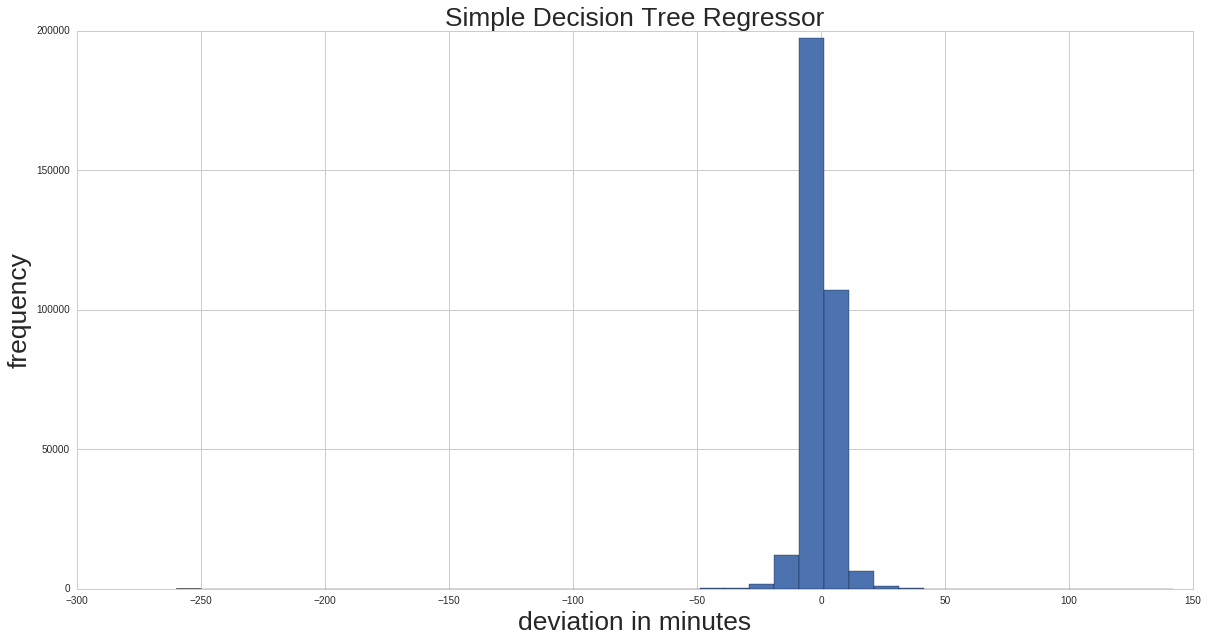

In [110]:
y_pred = regtree.predict(X_test)
np.linalg.norm(np.ceil(y_pred)-y_test)
diff = (y_pred-y_test)
# plt.figure(figsize=(12,10)) # not needed. set values globally
plt.hist(diff.values, bins=40)
print('Perzentile(%): ', [1,5,10,15,25,50,75,90,95,99], '\n', np.percentile(diff.values, [1,5,10,15,25,50,75,90,95,99]))
print('Absolute time deviation (in 1k): ', sum(abs(diff))/1000)
plt.title('Simple Decision Tree Regressor')
plt.xlabel('deviation in minutes')
plt.ylabel('frequency')

In [111]:
from sklearn.externals import joblib
joblib.dump(regtree, 'treelib/regtree_depth_30_PY27.pkl', protocol=2) 

['treelib/regtree_depth_30_PY27.pkl',
 'treelib/regtree_depth_30_PY27.pkl_01.npy',
 'treelib/regtree_depth_30_PY27.pkl_02.npy',
 'treelib/regtree_depth_30_PY27.pkl_03.npy']

In [112]:
regtree.tree_.max_depth

30

Perzentile(%):  [1, 5, 10, 15, 25, 50, 75, 90, 95, 99] 
 [-14.01453106  -6.6752769   -4.14994509  -2.85833333  -1.41638855
   0.49666667   2.09583333   3.8125       5.25416667   9.665     ]
Absolute time deviation (in 1k):  889.788218541


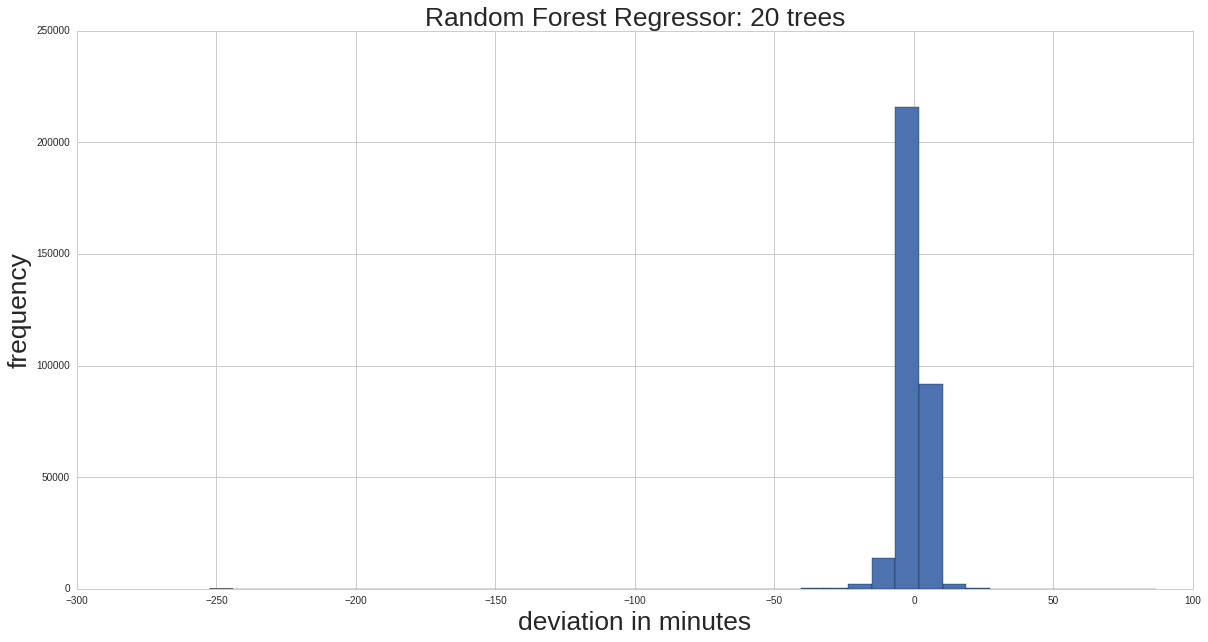

In [113]:
percentiles = [1,5,10,15,25,50,75,90,95,99]
y_pred = rd_regtree.predict(X_test)
np.linalg.norm(y_pred-y_test)
diff = (y_pred-y_test)
#plt.figure(figsize=(12,10))
plt.hist(diff.values, bins=40)
print('Perzentile(%): ', percentiles , '\n', np.percentile(diff.values, percentiles))
print('Absolute time deviation (in 1k): ', sum(abs(diff))/1000)
plt.title('Random Forest Regressor: 20 trees')
plt.xlabel('deviation in minutes')
plt.ylabel('frequency')

In [114]:
from sklearn.externals import joblib
joblib.dump(rd_regtree, 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl', protocol=2)

['randforlib/regtree_20x_depth_30_PY27.pkl.pkl',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_01.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_02.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_03.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_04.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_05.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_06.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_07.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_08.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_09.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_10.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_11.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_12.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_13.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_14.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_15.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_16.npy',
 'randforlib/regtree_20x_depth_30_PY27.pkl.pkl_17.npy',

In [115]:
! cd randforlib && zip regtree_20x_depth_30.zip regtree_20x_depth_30_PY27.pkl.pkl*

  adding: regtree_20x_depth_30_PY27.pkl.pkl (deflated 73%)
  adding: regtree_20x_depth_30_PY27.pkl.pkl_01.npy (deflated 19%)
  adding: regtree_20x_depth_30_PY27.pkl.pkl_02.npy (deflated 81%)
  adding: regtree_20x_depth_30_PY27.pkl.pkl_03.npy (deflated 70%)
  adding: regtree_20x_depth_30_PY27.pkl.pkl_04.npy (deflated 19%)
  adding: regtree_20x_depth_30_PY27.pkl.pkl_05.npy (deflated 81%)
  adding: regtree_20x_depth_30_PY27.pkl.pkl_06.npy (deflated 70%)
  adding: regtree_20x_depth_30_PY27.pkl.pkl_07.npy (deflated 19%)
  adding: regtree_20x_depth_30_PY27.pkl.pkl_08.npy (deflated 81%)
  adding: regtree_20x_depth_30_PY27.pkl.pkl_09.npy (deflated 70%)
  adding: regtree_20x_depth_30_PY27.pkl.pkl_10.npy (deflated 19%)
  adding: regtree_20x_depth_30_PY27.pkl.pkl_11.npy (deflated 81%)
  adding: regtree_20x_depth_30_PY27.pkl.pkl_12.npy (deflated 70%)
  adding: regtree_20x_depth_30_PY27.pkl.pkl_13.npy (deflated 19%)
  adding: regtree_20x_depth_30_PY27.pkl.pkl_14.npy (deflated 81%)
  adding: regtree

## Read as follows: Split # x results in the children_left[x] and children_right[x], etc. Means: go to the left, and then step by step to the right...

In [130]:
print('cleft: ' + str(regtree.tree_.children_left) + '\n\n', #array of left children
      'cright: ' + str(regtree.tree_.children_right) + '\n\n', #array of right children
    regtree.tree_.feature, '\n\n',#array of nodes splitting feature
    regtree.tree_.threshold, '\n\n', #array of nodes splitting points
    #regtree.tree_.value
     ) #array of nodes values

cleft: [   1    2    3 ..., 1605   -1   -1]

 cright: [ 894  507  254 ..., 1606   -1   -1]

 [ 4  6  5 ...,  5 -2 -2] 

 [-73.88609314 -73.87641144  40.71151733 ...,  40.83932495  -2.          -2.        ] 




numpy.ndarray(regtree.tree_.children_left #array of left children
regtree.tree_.children_right #array of right children
regtree.tree_.feature #array of nodes splitting feature
regtree.tree_.threshold #array of nodes splitting points
regtree.tree_.value #array of nodes values

## Finding leaves:

In [131]:
leaves = regtree.tree_.children_left*regtree.tree_.children_right
for idx, a in enumerate(leaves):
    if a==1:
        x=1# do nothing
    else:
        leaves[idx] = 0
print(leaves)

[0 0 0 ..., 0 1 1]


## Now we've found the leaves

In [132]:
regtree.tree_.compute_feature_importances()

array([ 0.00201552,  0.02067813,  0.05331978,  0.17284459,  0.30449187,
        0.13772981,  0.3089203 ])

# Seems that the first 3 features are quite irrelevant right now...

In [133]:
splits = regtree.tree_.threshold

[  7.5  10.5   5.5   5.5   7.5   9.5  20.5   9.5  17.5   6.5   7.5  17.5
  10.5   6.5  17.5   6.5   7.5   6.5  17.5   6.5   5.5   7.5   6.5   6.5
  17.5  10.5   7.5   7.5   7.5   6.5  19.5   6.5   6.5  17.5   7.5   6.5
   6.5   6.5  18.5  18.5   6.5  10.5   5.5   5.5   7.5  19.5  18.5   4.5
  11.5   6.5  17.5   6.5   9.5   7.5   8.5   9.5   0.5  19.   14.5   4.5
  17.5   9.5   6.5  17.5   2.5  20.5   6.5  18.5   3.5  14.5  20.5   4.5
  14.   20.    9.5   2.5  17.5  15.5  11.   13.5  12.5   8.5   2.    1.5
  10.5  16.5   6.5  14.5   4.5  14.5  11.5  17.5   4.5   7.5  17.5  10.5
   7.5  19.   17.   13.5   8.5  18.5  19.5  12.5   8.5  15.5  14.5  22.5
   7.5   3.5  13.5   4.5   1.5   9.5   6.5   3.5   6.5   3.5   8.5   6.5
   9.5   8.5   6.5   7.5   0.5   5.5   8.5  10.5  17.5   3.5  16.5  14.5
  11.5   3.5   2.5  11.5  18.5  10.5   4.5   6.5  19.5  22.5  19.5  15.5
  21.   13.5   7.5  13.5  13.5   6.5  14.5  17.5  12.5   5.   10.5   7.5
  10.5   3.5   4.5  18.5   7.5   4.5   5.5   3.   2

(array([ 10.,  21.,  36.,  27.,  22.,  18.,  12.,  20.,  19.,  10.]),
 array([  0.5,   2.7,   4.9,   7.1,   9.3,  11.5,  13.7,  15.9,  18.1,
         20.3,  22.5]),
 <a list of 10 Patch objects>)

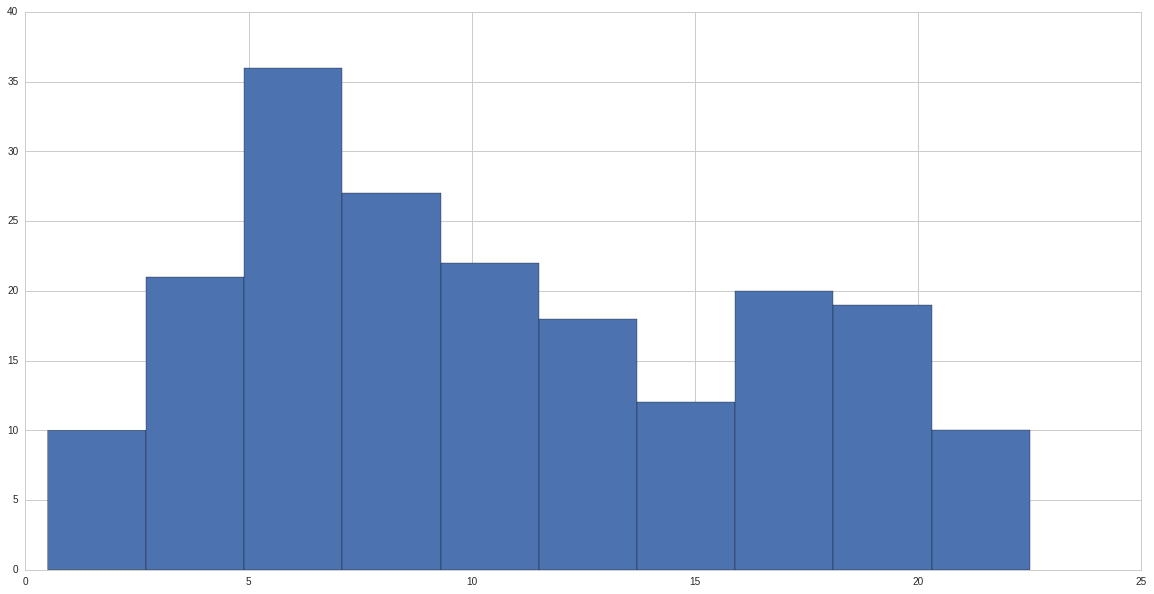

In [134]:
time_splits = splits[(splits>=0) & (splits<=24)]
print(time_splits)
plt.hist(time_splits)

# Where are splits in the hour?

# Filter the splits in longitudinal and latitudinal data

In [135]:
long_splits = splits[(splits>=-75) & (splits<=-70)]
lat_splits = splits[(splits>=40) & (splits<=41)]

# <font color = 'red'> The MSE of each node is stored in the 'impurity'-property. </font color>

In [136]:
#np.multiply(regtree.tree_.value, 1/ regtree.tree_.n_node_samples).size
avg_time_dev = regtree.tree_.impurity.T  * leaves
#avg_time_dev = (np.array(regtree.tree_.value)/np.array(regtree.tree_.n_node_samples)) *np.array(leaves)
avg_time_dev = avg_time_dev[avg_time_dev!=0]

In [137]:
avg_time_dev

array([  2.98089772e+01,   2.39769852e+01,   3.13388607e+01,
         2.25332896e+01,   2.22804048e+01,   2.99869810e+01,
         3.83369750e+01,   2.07098672e+01,   2.49863999e+01,
         3.77843762e+01,   3.68750000e+00,   1.60710059e+01,
         1.53722751e+01,   2.27125283e+01,   2.16740895e+01,
         1.81328277e+01,   2.32361592e+01,   2.88596873e+01,
         2.24318451e+01,   3.06682575e+01,   4.13069070e+01,
         4.40175256e+01,   2.16962707e+01,   5.83257618e+01,
         2.71539050e+01,   3.55195072e+01,   3.75072676e+01,
         3.25642177e+01,   2.99232070e+01,   2.76129658e+01,
         1.57879788e+01,   4.18594231e+01,   4.21534048e+01,
         2.20587055e+01,   3.48223561e+01,   3.56734211e+01,
         3.61657643e+01,   2.69355102e+01,   9.62162162e+01,
         6.51634349e+01,   2.21484900e+01,   2.22534582e+01,
         4.93639922e+01,   2.61742245e+01,   3.18070081e+01,
         5.54020911e+01,   1.63907765e+01,   1.34724911e+01,
         1.03401265e+01,

In [138]:
regtree.tree_.compute_feature_importances()

array([ 0.00201552,  0.02067813,  0.05331978,  0.17284459,  0.30449187,
        0.13772981,  0.3089203 ])

(array([  87.,   63.,  108.,   87.,   60.,   50.,   26.,   35.,   33.,
          20.,   16.,   13.,   13.,   13.,    4.,    3.,    7.,    2.,
           7.,    5.,    4.,    2.,    3.,    1.,    3.,    2.,    3.,
           1.,    1.,    2.,    3.,    1.,    2.,    2.,    0.,    1.,
           1.,    1.,    0.,    0.,    1.,    1.,    1.,    0.,    0.,
           0.,    0.,    1.,    1.,    0.]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
         270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,
         360.,  370.,  380.,  390.,  400.,  410.,  420.,  430.,  440.,
         450.,  460.,  470.,  480.,  490.,  500.]),
 <a list of 50 Patch objects>)

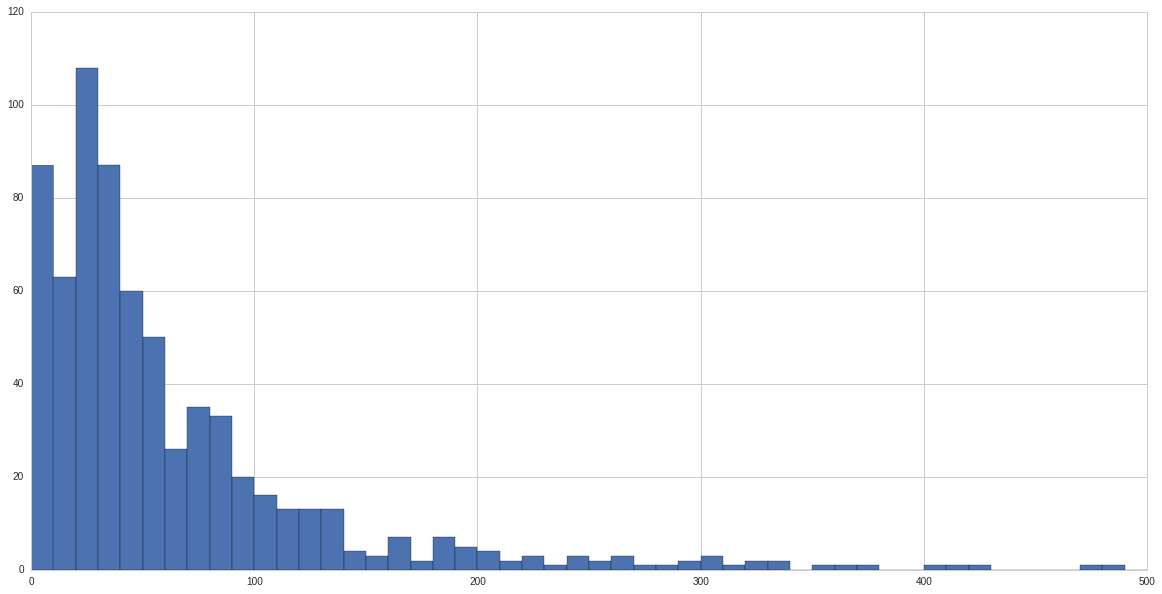

In [139]:
h = avg_time_dev
plt.hist(h.tolist(), bins=50, range=[0, 500])

In [140]:
np.percentile(avg_time_dev, q=[5, 50, 75, 90, 95, 97.5, 99])

array([   2.25      ,   40.40453686,   80.65816075,  144.65208316,
        233.20489438,  328.16237289,  488.59704894])

In [142]:
time_regression_df.columns[0:7]

Index(['pickup_datetime_day', 'pickup_datetime_dayofweek',
       'pickup_datetime_hour', 'pickup_latitude', 'pickup_longitude',
       'dropoff_latitude', 'dropoff_longitude'],
      dtype='object')

# <font color = 'blue'> Now we want to visualize the decision tree. To do so, plot the splits in geodata on the map of NYC (together with the heat map) </font color>

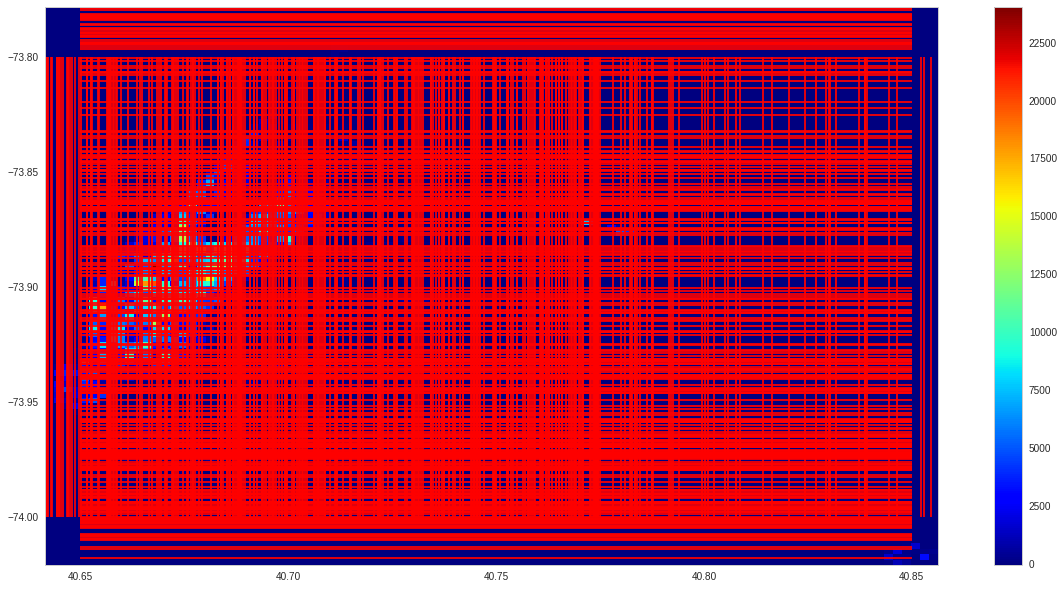

In [143]:
x = data_in_box.pickup_latitude
y = data_in_box.pickup_longitude

H, xedges, yedges = np.histogram2d(x, y, bins=100, normed=False, weights=None)

plt.jet()
fig = plt.figure(figsize=(20, 10))
#ax.set_title('pcolormesh: exact bin edges')
X, Y = np.meshgrid(xedges, yedges)
mesh = plt.pcolormesh(X, Y, H)
plt.colorbar(mesh)
#ax.set_aspect('equal')
#plt.savefig('figure.pdf', format='pdf')
#plt.savefig('figure.png', format='png')

## Plot the horizontal / vertival lines here via eventplot
plt.hold(True)
plt.eventplot(lat_splits, orientation='horizontal', lineoffsets=-73.9,
          linelengths=0.2, linewidths=None, color = [[1,0,0]],
          linestyles='solid')
plt.eventplot(long_splits, orientation='vertical', lineoffsets=40.75,
          linelengths=.2, linewidths=None, color = [[1,0,0]],
          linestyles='solid')
plt.axis([xedges.min(),xedges.max(),yedges.min(),yedges.max()]) # zoom in
plt.hold(False)